## Reads in regridded data and looks at direction of trends
- starting with T and P, given results from CONUS snow with Univ of AZ plots

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

%matplotlib inline

### Fetch cluster

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='20GB')
cluster.scale(20) #100 for whole dataset
cluster

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [4]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [5]:
## Updated for new directory structure of LENS2
def file_dict(model,mem,field,hist=True,freq='monthly',component='lnd'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]

    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+ \
                  component+'/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/'+ \
                   component+'/proc/tseries/'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            if component == 'lnd': tape    = '.h5.'
            if component == 'atm': tape    = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'

        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'

        #find all the relevant files
        files = glob.glob(thisdir+runtype+mm+'*'+tape+field+'*')

    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths

In [6]:
def get_file(model,mem,field,year,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [7]:
def all_files(model,ens,field,firstyear,lastyear,freq='monthly',component='lnd'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq,component)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [8]:
def get_data(model,ens,fields,preprocess,firstyear,lastyear,freq,chunks={'time':1000},component='lnd'):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,freq,component)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,preprocess=preprocess,
                                    combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,preprocess=preprocess,
                                       combine='nested',parallel=True,
                                       concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [9]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    la.attrs['units'] = ds['area'].attrs['units']
    return la

In [10]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

---------
#### Read in observations

In [11]:
obsDir = '/glade/scratch/wwieder/VernalWindow/'
tas = xr.open_mfdataset(obsDir+'tas.nc').sel(lat=slice(25,85))
pr  = xr.open_mfdataset(obsDir+'pr.nc').sel(lat=slice(25,85))
swe = xr.open_mfdataset(obsDir+'swe.nc').sel(lat=slice(25,85))


In [80]:
# calculate mean annual JFM trends
s2d = 3600 * 24
tas_win = tas.tas.where(tas.time['time.month']<=3)#1979-2012
tas_win = tas_win.groupby(tas_win.time['time.year']).mean('time')
pr_win = pr.pr.where(pr.time['time.month']<=3) #1979-2012, units mm/s
# sum for all days in months
pr_win = pr_win.groupby(pr_win.time['time.year']).mean('time') * s2d * (31+28+31) # 
pr_win.attrs['units'] = 'mm'
minY, maxY = tas_win.year.min(), tas_win.year.max()
pr.pr

<xarray.DataArray 'pr' (time: 408, lat: 63, lon: 288)>
dask.array<getitem, shape=(408, 63, 288), dtype=float64, chunksize=(408, 63, 288), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1979-01-16 12:00:00 ... 2012-12-16 12:00:00
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35
Attributes:
    units:      kg m-2 s-1
    long_name:  precipitation

#### Read in monthly data from CESM2-LE

In [82]:
%%time
model = 'CESM2'

#ens = 10+np.arange(40)
# doesn't seem to work starting with #10?
ens = 10+np.arange(40)
nens = len(ens)

fields = ['H2OSNO','RAIN','SNOW','TBOT']


firstyear = 1970
lastyear  = 2020
freq      = 'monthly'
preprocess = None


with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = get_data(model,ens,fields,preprocess,firstyear,lastyear,freq,component='lnd').persist()
    _ = wait(ds)

fields = ['TREFHT']#,'FAREA_BURNED']
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds2 = get_data(model,ens,fields,preprocess,firstyear,lastyear,freq,component='atm').persist()
    _ = wait(ds2)

    # Add TREFHT to ds
ds2['lat'] = ds['lat']
ds2['lon'] = ds['lon']
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds['TREFHT'] = ds2['TREFHT']
    
print(ds.nbytes/1e9) #GB 

27.112299628
CPU times: user 26.1 s, sys: 1.78 s, total: 27.9 s
Wall time: 44.5 s


#### Mask out regions to be consistent with daily analyses

 -- Data mask read in -- 


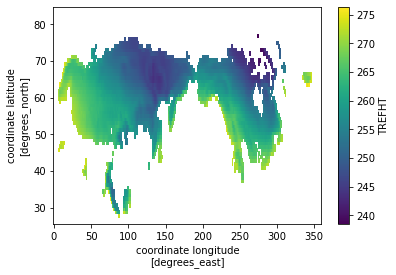

In [83]:
# we'll just look at 25-85 N for convenience
la = get_landarea(model)
ds = ds.sel(lat=slice(25,85))
la = la.sel(lat=slice(25,85))

# use daily results to create mask
pathIN = '/glade/scratch/wwieder/VernalWindow/'
fileIN =  pathIN + 'SnowStatsSWE*.nc'

dsMask = xr.open_mfdataset(fileIN,combine='nested',parallel=True, concat_dim=['ens'])

#dsMask = dsMask.MaxSnow.persist()
_ = wait(dsMask)
dsMask2 = dsMask['SnowFree'].isel(time=slice(0,10)).mean('time').max('ens')
#dsMask2.plot(robust=True)

ds = ds.where(dsMask2>0)
la = la.where(dsMask2>0)
print(' -- Data mask read in -- ')

# additional aggregation for JFM data in simulations.
ds_win = ds.where(ds.time['time.month']<=3)#1979-2012
ds_win = ds_win.groupby(ds_win.time['time.year']).mean('time')
ds_win = ds_win.sel(year = slice(minY,maxY))
ds_win.TREFHT.mean(['ens','year']).plot() ;

In [93]:
# additonal calculations
ds_win['pr'] = (ds_win.RAIN+ds_win.SNOW) * s2d * (31+28+31) # sum for all winter days
tas_win = tas_win.where(dsMask2>0)
pr_win = pr_win.where(dsMask2>0)
ds.SNOW

,Array,Chunk
Bytes,1.65 GiB,8.31 MiB
Shape,"(40, 612, 63, 288)","(1, 120, 63, 288)"
Count,750 Tasks,240 Chunks
Type,float32,numpy.ndarray


-----------
### Now calculate trends

In [85]:
# colorbrewer colormap, diverging, brown->blue
ccc = np.zeros([15,3]);
ccc[14,:] = 39, 129, 240
ccc[13,:] = 59, 150, 244
ccc[12,:] = 80, 165, 244
ccc[11,:] = 124, 184, 249
ccc[10,:] = 150, 210, 249
ccc[9,:] = 179, 240, 249
ccc[8,:] = 224, 255, 255 
ccc[7,:] = 255, 255, 255
ccc[6,:] = 249, 240, 239
ccc[5,:] = 240, 220, 210
ccc[4,:] = 224, 190, 179
ccc[3,:] = 199, 159, 150
ccc[2,:] = 179, 140, 129
ccc[1,:] = 159, 120, 109
ccc[0,:] = 140, 100, 89
ccc = matplotlib.colors.ListedColormap(ccc/256)

ddd = np.zeros([13,3]); 
ddd[0,:] = 182, 106,  40
ddd[1,:] = 205, 133,  63
ddd[2,:] = 225, 165, 100
ddd[3,:] = 245, 205, 132
ddd[4,:] = 245, 224, 158
ddd[5,:] = 255, 245, 186
ddd[6,:] = 255, 255, 255
ddd[7,:] = 205, 255, 205
ddd[8,:] = 153, 240, 178
ddd[9,:] =  83, 189, 159
ddd[10,:] = 110, 170, 200
ddd[11,:] =   5, 112, 176
ddd[12,:] =   2,  56,  88
ddd = matplotlib.colors.ListedColormap(ddd/256)

In [86]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
from matplotlib.colors import from_levels_and_colors

# Generate a function for making panel plots of maps
def map_function(da, cb=0, cmap='viridis', panel=None,  ax=None, 
                 title=None, vmax=None, vmin=None, units=None, norm=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()

    cmap = copy.copy(plt.get_cmap(cmap))
    cmap.set_bad( "gray", alpha=0.10 )
    cmap.set_under( "white", alpha=1 )

    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                       transform=ccrs.PlateCarree(),
                       vmax=vmax,vmin=vmin,cmap=cmap,
                       norm=norm)

    ax.set_title(title,loc='left', fontsize='large', fontweight='bold')
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.90), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    
    ocean = ax.add_feature(
        cfeature.NaturalEarthFeature('physical','ocean','110m', facecolor='white'))
    # allows for different colorbars on each plot
    if cb == 1:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='horizontal')
        cbar.set_label(units,size=12,fontweight='bold')
    if cb == 2:
        cbar = fig.colorbar(im, ax=ax,pad=0.02, fraction = 0.05, orientation='vertical')    
        cbar.set_label(units,size=12)#,weight='bold')


---
### Trends, temperature

41


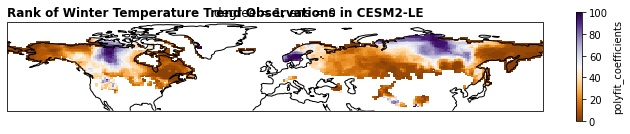

In [106]:
# Calculate temperatutre trends, bias and rank of observatiosn w/in ensemble
tas_trend = tas_win.polyfit('year',1)
cesm_tas_trend = ds_win.TREFHT.polyfit('year',1)
tas_bias = cesm_tas_trend.polyfit_coefficients.isel(degree=0).mean('ens') - \
                tas_trend.polyfit_coefficients.isel(degree=0)
combined = xr.combine_nested([cesm_tas_trend, tas_trend.expand_dims("ens")], 'ens')
nens = len(combined.ens)
ranked = combined.polyfit_coefficients.isel(degree=0).compute().rank('ens').isel(ens=(nens-1))
print(nens)
ranked = ranked / nens * 100
ranked = ranked.where(ranked>(1/nens), 0) #/41 * 100
ranked = ranked.where(ranked<100, 100) #/41 * 100
ranked = ranked.where(ds_win.TREFHT.max(['year','ens'])>0)

plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Rank of Winter Temperature Trend Observations in CESM2-LE', loc='left', fontsize='large', fontweight='bold') ;
ranked.plot(vmax=100,vmin=0,cmap='PuOr')
ax.coastlines();

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


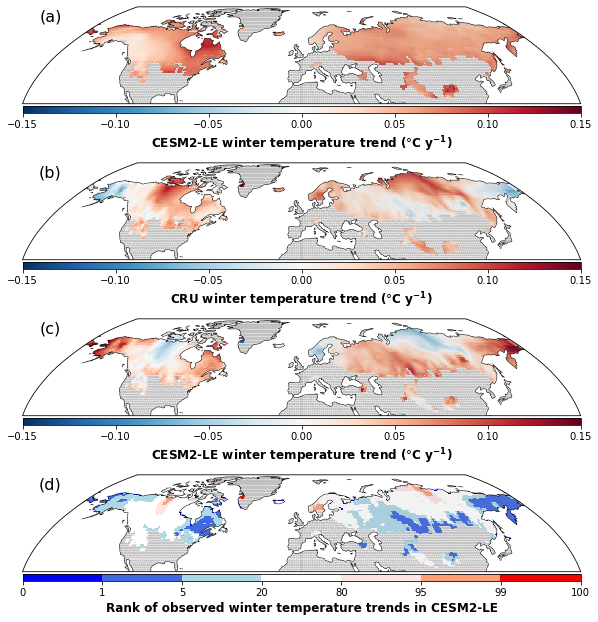

In [107]:
# Now plot temperature trends
panel = ['(a)','(b)','(c)','(d)']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,11), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    if i == 0:
        da = cesm_tas_trend.polyfit_coefficients.isel(degree=0).mean('ens')
        cmap, units ='RdBu_r',"CESM2-LE winter temperature trend ($\degree$C $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 0.15, -0.15, 1
        norm=None
    if i == 1:
        da = tas_trend.polyfit_coefficients.isel(degree=0)
        cmap, units ='RdBu_r',"CRU winter temperature trend ($\degree$C $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 0.15, -0.15, 1

    if i == 2: 
        da = tas_bias
        cmap, units = 'RdBu_r', "CESM2-LE winter temperature trend ($\degree$C $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 0.15, -0.15, 1
        
    if i == 3: 
        da = ranked
        cmap, units='PuOr', 'Rank of observed winter temperature trends in CESM2-LE'
        vmax, vmin,cb = None,None, 1
        cmap , norm = from_levels_and_colors([0, 1, 5, 20 , 80, 95, 99,100.01], 
                        ['blue','royalblue','lightblue','white', 'mistyrose','lightsalmon','red'])
        
    map_function(da, panel=panel[i], ax=ax, 
                 cmap=cmap, units= units,
                 vmax=vmax,vmin=vmin,cb=cb, norm=norm)

    i = i+1

---
### Trends, winter precip

41


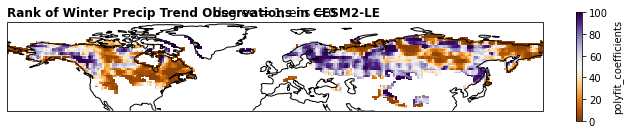

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job al

In [108]:
# Calculate temperatutre trends, bias and rank of observatiosn w/in ensemble
pr_trend = pr_win.polyfit('year',1)
cesm_pr_trend = ds_win.pr.polyfit('year',1)
pr_bias = cesm_pr_trend.polyfit_coefficients.isel(degree=0).mean('ens') - \
                pr_trend.polyfit_coefficients.isel(degree=0)
combined = xr.combine_nested([cesm_pr_trend, pr_trend.expand_dims("ens")], 'ens')
nens = len(combined.ens)
ranked = combined.polyfit_coefficients.isel(degree=0).compute().rank('ens').isel(ens=(nens-1))
print(nens)
ranked = ranked / nens * 100
ranked = ranked.where(ranked>(1/nens), 0) #/41 * 100
ranked = ranked.where(ranked<100, 100) #/41 * 100
ranked = ranked.where(ds_win.TREFHT.max(['year','ens'])>0)

plt.figure(figsize=[12,2])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Rank of Winter Precip Trend Observations in CESM2-LE', loc='left', fontsize='large', fontweight='bold') ;
ranked.plot(vmax=100,vmin=0,cmap='PuOr')
ax.coastlines();

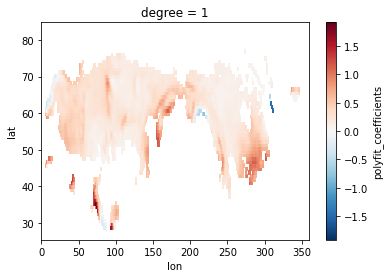

In [104]:
cesm_pr_trend.polyfit_coefficients.isel(degree=0).mean('ens').plot() ;

/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:310: UserWarning: The colormap's 'bad' has been set, but in order to wrap pcolormesh across the map it must be fully transparent.
  return func(self, *args, **kwargs)
/glade/u/home/wwieder/miniconda3/envs/lens-py/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


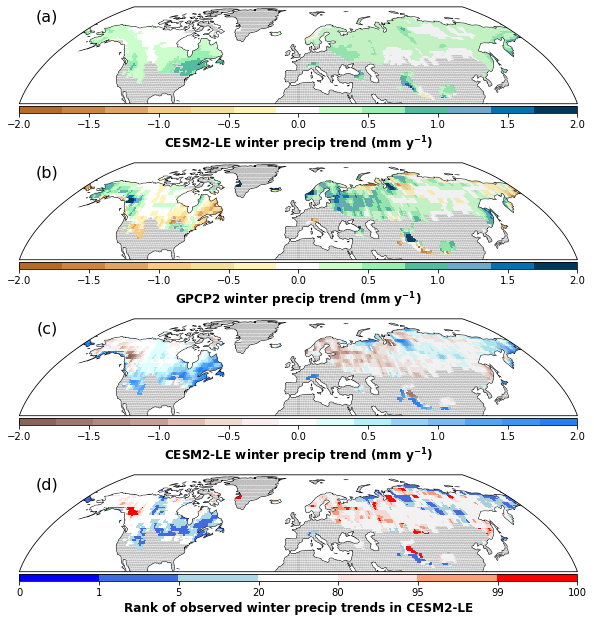

In [105]:
# Now plot temperature trends
panel = ['(a)','(b)','(c)','(d)']
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,11), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
i = 0
for index, ax in np.ndenumerate(axes):
    if i == 0:
        da = cesm_pr_trend.polyfit_coefficients.isel(degree=0).mean('ens')
        cmap, units =ddd,"CESM2-LE winter precip trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 2, -2, 1
        norm=None
    if i == 1:
        da = pr_trend.polyfit_coefficients.isel(degree=0)
        cmap, units =ddd,"GPCP2 winter precip trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 2, -2, 1

    if i == 2: 
        da = pr_bias
        cmap, units = ccc, "CESM2-LE winter precip trend (mm $\mathregular{y^{-1}}$)"
        vmax, vmin, cb = 2, -2, 1
        
    if i == 3: 
        da = ranked
        cmap, units='PuOr', 'Rank of observed winter precip trends in CESM2-LE'
        vmax, vmin,cb = None,None, 1
        cmap , norm = from_levels_and_colors([0, 1, 5, 20 , 80, 95, 99,100.01], 
                        ['blue','royalblue','lightblue','white', 'mistyrose','lightsalmon','red'])
        
    map_function(da, panel=panel[i], ax=ax, 
                 cmap=cmap, units= units,
                 vmax=vmax,vmin=vmin,cb=cb, norm=norm)

    i = i+1